# Normalizing Flows

## What are Normalizing Flows?

Normalizing Flows are a class of generative models that learn invertible transformations between a simple base distribution (e.g., Gaussian) and a complex target distribution. Unlike VAEs or GANs, flows provide:

1. **Exact likelihood computation**: We can compute the exact probability of any data point
2. **Exact sampling**: We can generate samples by transforming samples from the base distribution
3. **Invertible transformations**: We can map between data and latent space in both directions

### Key Concepts:

1. **Change of Variables Formula**: Used to compute likelihood under transformation
2. **Jacobian Determinant**: Measures how volume changes under transformation
3. **Invertible Layers**: Building blocks that can be inverted analytically
4. **Coupling Layers**: Common architecture that preserves invertibility

### Mathematical Foundation:

For an invertible transformation $f: \mathbb{R}^d \to \mathbb{R}^d$:

$$p_X(x) = p_Z(f^{-1}(x)) \left| \det \frac{\partial f^{-1}}{\partial x} \right|$$

Where:
- $p_Z$ is the base distribution (usually Gaussian)
- $p_X$ is the target distribution we want to model
- The Jacobian determinant accounts for volume changes

In this tutorial, we'll implement various flow architectures and explore their capabilities.

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm import tqdm
from sklearn.datasets import make_moons, make_circles, make_swiss_roll
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define base classes first
class FlowLayer(nn.Module):
    """Base class for flow layers"""
    def __init__(self):
        super(FlowLayer, self).__init__()
    
    def forward(self, x):
        raise NotImplementedError
    
    def inverse(self, x):
        raise NotImplementedError
    
    def log_det_jacobian(self, x):
        raise NotImplementedError

class PositionalEncoding(nn.Module):
    """Positional encoding from Transformer architecture"""
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class PlanarFlow(FlowLayer):
    """Planar flow transformation"""
    def __init__(self, dim):
        super(PlanarFlow, self).__init__()
        self.dim = dim
        self.u = nn.Parameter(torch.randn(1, dim) * 0.01)
        self.w = nn.Parameter(torch.randn(1, dim) * 0.01)
        self.b = nn.Parameter(torch.randn(1) * 0.01)
    
    def forward(self, x):
        """Forward transformation: f(x) = x + u * tanh(w^T x + b)"""
        # Ensure invertibility constraint: w^T u >= -1
        wtu = torch.sum(self.w * self.u, dim=1, keepdim=True)
        m_wtu = -1 + torch.log(1 + torch.exp(wtu))
        u_hat = self.u + (m_wtu - wtu) * self.w / torch.sum(self.w**2, dim=1, keepdim=True)
        
        activation = torch.tanh(torch.mm(x, self.w.t()) + self.b)
        return x + u_hat * activation
    
    def log_det_jacobian(self, x):
        """Log determinant of Jacobian"""
        # Ensure invertibility constraint
        wtu = torch.sum(self.w * self.u, dim=1, keepdim=True)
        m_wtu = -1 + torch.log(1 + torch.exp(wtu))
        u_hat = self.u + (m_wtu - wtu) * self.w / torch.sum(self.w**2, dim=1, keepdim=True)
        
        activation = torch.tanh(torch.mm(x, self.w.t()) + self.b)
        psi = (1 - activation**2) * self.w
        det_grad = 1 + torch.mm(psi, u_hat.t())
        return torch.log(torch.abs(det_grad) + 1e-8).squeeze()

class RadialFlow(FlowLayer):
    """Radial flow transformation"""
    def __init__(self, dim):
        super(RadialFlow, self).__init__()
        self.dim = dim
        self.x0 = nn.Parameter(torch.randn(1, dim) * 0.01)
        self.alpha = nn.Parameter(torch.randn(1) * 0.01)
        self.beta = nn.Parameter(torch.randn(1) * 0.01)
    
    def forward(self, x):
        """Forward transformation"""
        diff = x - self.x0
        r = torch.norm(diff, dim=1, keepdim=True)
        h = 1 / (self.alpha + r)
        return x + self.beta * h * diff
    
    def log_det_jacobian(self, x):
        """Log determinant of Jacobian"""
        diff = x - self.x0
        r = torch.norm(diff, dim=1, keepdim=True)
        h = 1 / (self.alpha + r)
        h_prime = -h**2
        
        det = (1 + self.beta * h)**self.dim + self.beta * h_prime * r
        return torch.log(torch.abs(det) + 1e-8).squeeze()

print("Flow classes defined successfully!")

Using device: cpu
Flow classes defined successfully!


## Understanding the Change of Variables Formula

Let's start by visualizing how transformations affect probability distributions

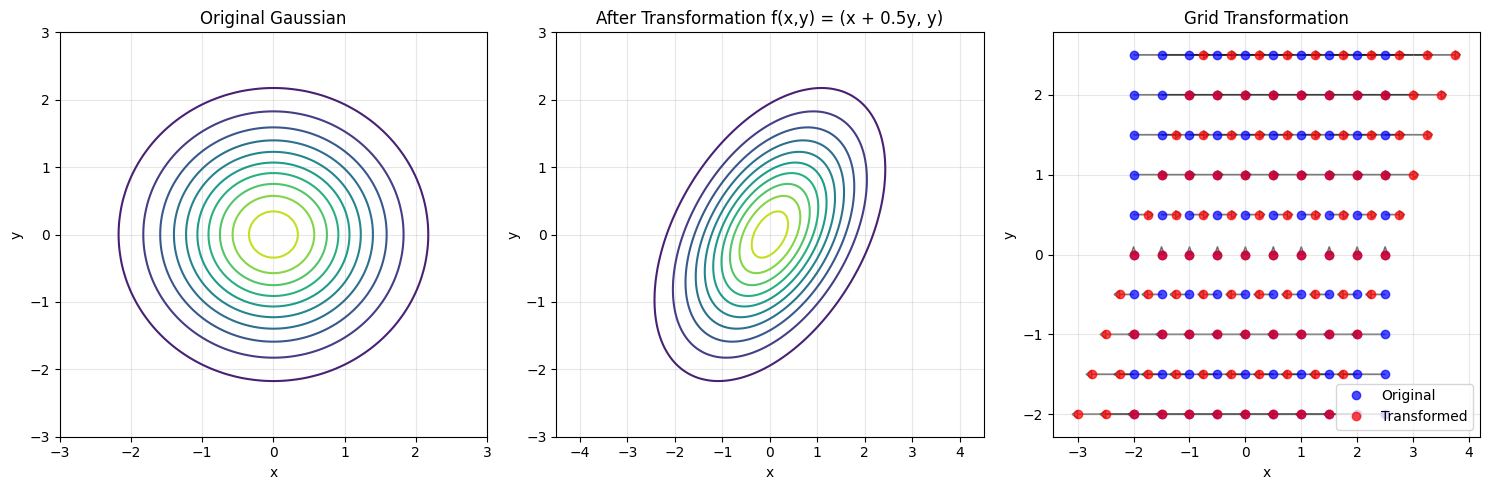

In [2]:
def visualize_transformation_2d():
    """Visualize how a simple transformation affects a 2D distribution"""
    
    # Create a grid
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-3, 3, 100)
    X, Y = np.meshgrid(x, y)
    
    # Original Gaussian distribution
    Z_orig = np.exp(-0.5 * (X**2 + Y**2)) / (2 * np.pi)
    
    # Apply a simple transformation: [x, y] -> [x + 0.5*y, y]
    X_transformed = X + 0.5 * Y
    Y_transformed = Y
    
    # Jacobian determinant for this transformation is 1
    # So the density stays the same
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original distribution
    im1 = axes[0].contour(X, Y, Z_orig, levels=10)
    axes[0].set_title('Original Gaussian')
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('y')
    axes[0].grid(True, alpha=0.3)
    
    # Transformation visualization
    axes[1].contour(X_transformed, Y_transformed, Z_orig, levels=10)
    axes[1].set_title('After Transformation f(x,y) = (x + 0.5y, y)')
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('y')
    axes[1].grid(True, alpha=0.3)
    
    # Show the transformation effect on a grid
    x_grid = np.arange(-2, 3, 0.5)
    y_grid = np.arange(-2, 3, 0.5)
    X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
    X_grid_flat = X_grid.flatten()
    Y_grid_flat = Y_grid.flatten()
    
    # Transform grid points
    X_trans_flat = X_grid_flat + 0.5 * Y_grid_flat
    Y_trans_flat = Y_grid_flat
    
    axes[2].plot(X_grid_flat, Y_grid_flat, 'bo', alpha=0.7, label='Original')
    axes[2].plot(X_trans_flat, Y_trans_flat, 'ro', alpha=0.7, label='Transformed')
    
    # Draw arrows to show transformation
    for i in range(len(X_grid_flat)):
        axes[2].arrow(X_grid_flat[i], Y_grid_flat[i], 
                     X_trans_flat[i] - X_grid_flat[i], 
                     Y_trans_flat[i] - Y_grid_flat[i],
                     head_width=0.1, head_length=0.1, fc='gray', alpha=0.5)
    
    axes[2].set_title('Grid Transformation')
    axes[2].set_xlabel('x')
    axes[2].set_ylabel('y')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

visualize_transformation_2d()

## Creating 2D Toy Datasets

Let's create some interesting 2D distributions to model with flows

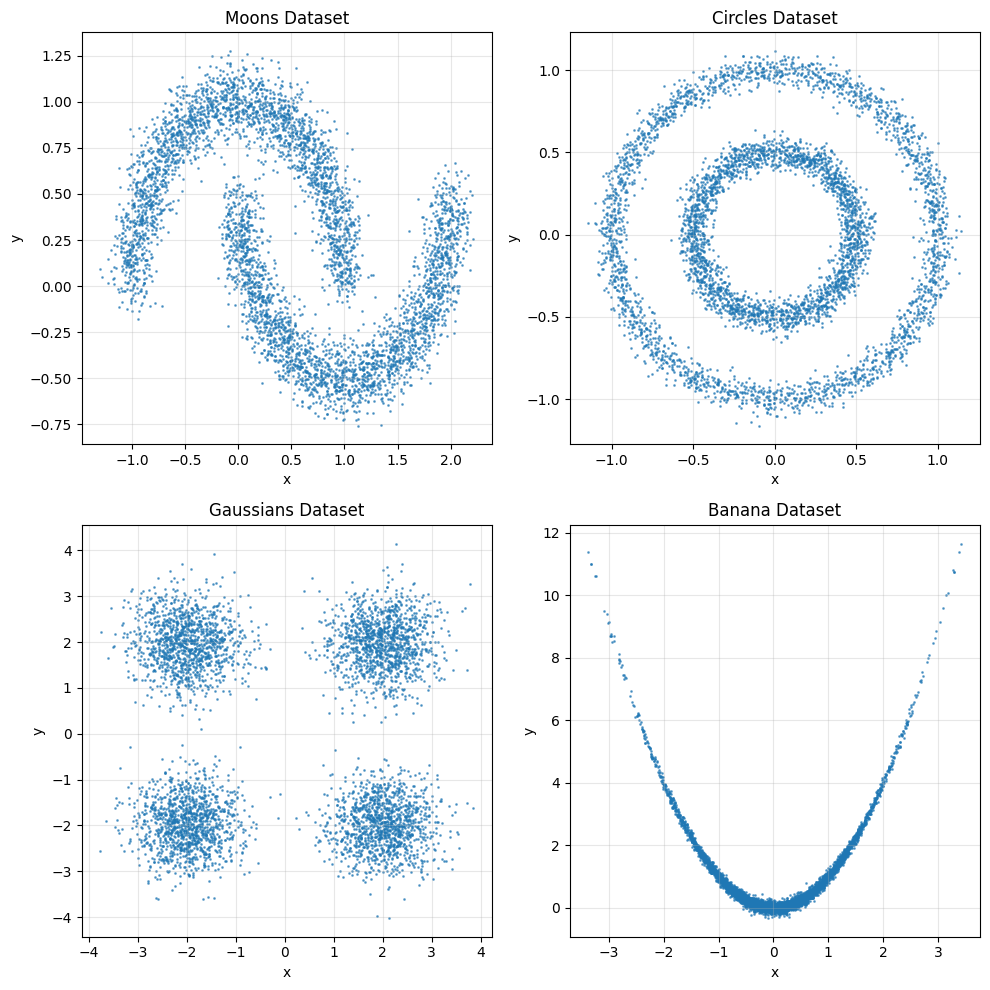

In [3]:
def create_toy_datasets(n_samples=5000):
    """Create various 2D toy datasets"""
    datasets = {}
    
    # Two moons
    moons_data, _ = make_moons(n_samples=n_samples, noise=0.1, random_state=42)
    datasets['moons'] = torch.FloatTensor(moons_data)
    
    # Two circles
    circles_data, _ = make_circles(n_samples=n_samples, noise=0.05, factor=0.5, random_state=42)
    datasets['circles'] = torch.FloatTensor(circles_data)
    
    # Mixture of Gaussians
    means = [[-2, -2], [2, 2], [-2, 2], [2, -2]]
    gaussian_data = []
    for mean in means:
        samples = np.random.multivariate_normal(mean, [[0.3, 0], [0, 0.3]], n_samples // 4)
        gaussian_data.append(samples)
    gaussian_data = np.vstack(gaussian_data)
    datasets['gaussians'] = torch.FloatTensor(gaussian_data)
    
    # Banana distribution
    x = np.random.normal(0, 1, n_samples)
    y = x**2 + np.random.normal(0, 0.1, n_samples)
    banana_data = np.column_stack([x, y])
    datasets['banana'] = torch.FloatTensor(banana_data)
    
    return datasets

def plot_datasets(datasets):
    """Plot the toy datasets"""
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()
    
    for i, (name, data) in enumerate(datasets.items()):
        axes[i].scatter(data[:, 0], data[:, 1], alpha=0.6, s=1)
        axes[i].set_title(f'{name.capitalize()} Dataset')
        axes[i].set_xlabel('x')
        axes[i].set_ylabel('y')
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create and visualize datasets
toy_datasets = create_toy_datasets()
plot_datasets(toy_datasets)

## Building Basic Flow Components

Let's implement the fundamental building blocks of normalizing flows

In [4]:
# def visualize_positional_encoding():
#     d_model = 128
#     max_len = 100
    
#     pe = PositionalEncoding(d_model, max_len)
    
#     # Get the positional encoding matrix
#     pos_encoding = pe.pe[0, :max_len, :].detach().numpy()
    
#     plt.figure(figsize=(12, 8))
    
#     # Plot the first few dimensions
#     plt.subplot(2, 2, 1)
#     plt.plot(pos_encoding[:, :4])
#     plt.title('First 4 dimensions of positional encoding')
#     plt.xlabel('Position')
#     plt.ylabel('Encoding value')
#     plt.legend(['dim 0', 'dim 1', 'dim 2', 'dim 3'])
    
#     # Heatmap of positional encodings
#     plt.subplot(2, 2, 2)
#     plt.imshow(pos_encoding[:50, :50].T, aspect='auto', cmap='RdBu')
#     plt.title('Positional Encoding Heatmap')
#     plt.xlabel('Position')
#     plt.ylabel('Dimension')
#     plt.colorbar()
    
#     # Show how different frequencies evolve
#     plt.subplot(2, 2, 3)
#     dims_to_plot = [0, 2, 4, 8, 16, 32]
#     for dim in dims_to_plot:
#         plt.plot(pos_encoding[:50, dim], label=f'dim {dim}')
#     plt.title('Different frequency components')
#     plt.xlabel('Position')
#     plt.ylabel('Encoding value')
#     plt.legend()
    
#     # 2D visualization instead of 3D for compatibility
#     plt.subplot(2, 2, 4)
#     plt.plot(pos_encoding[:50, 0], pos_encoding[:50, 1], 'b-', alpha=0.7)
#     # Fix the scatter plot by ensuring color array matches data size
#     scatter_indices = slice(0, 50, 5)
#     scatter_x = pos_encoding[scatter_indices, 0]
#     scatter_y = pos_encoding[scatter_indices, 1]
#     scatter_colors = np.arange(len(scatter_x)) * 5  # Create colors that match the actual data length
    
#     plt.scatter(scatter_x, scatter_y, c=scatter_colors, cmap='viridis')
#     plt.xlabel('Dim 0')
#     plt.ylabel('Dim 1')
#     plt.title('2D view of first 2 dimensions')
#     plt.colorbar(label='Position')
    
#     plt.tight_layout()
#     plt.show()

# visualize_positional_encoding()

## Building a Normalizing Flow Model

In [5]:
class NormalizingFlow(nn.Module):
    """Normalizing Flow model"""
    def __init__(self, dim, flow_type='planar', n_flows=10):
        super(NormalizingFlow, self).__init__()
        self.dim = dim
        self.n_flows = n_flows
        
        # Create flow layers
        self.flows = nn.ModuleList()
        for _ in range(n_flows):
            if flow_type == 'planar':
                self.flows.append(PlanarFlow(dim))
            elif flow_type == 'radial':
                self.flows.append(RadialFlow(dim))
            else:
                raise ValueError(f"Unknown flow type: {flow_type}")
        
        # Base distribution (standard Gaussian)
        self.register_buffer('base_mu', torch.zeros(dim))
        self.register_buffer('base_sigma', torch.ones(dim))
    
    def forward(self, z):
        """Transform from base distribution to data distribution"""
        x = z
        log_det_sum = 0
        
        for flow in self.flows:
            log_det_sum += flow.log_det_jacobian(x)
            x = flow.forward(x)
        
        return x, log_det_sum
    
    def sample(self, n_samples):
        """Generate samples from the model"""
        z = torch.randn(n_samples, self.dim).to(self.base_mu.device)
        x, _ = self.forward(z)
        return x
    
    def log_prob(self, x):
        """Compute log probability of data points"""
        # For exact log probability, we need the inverse transformation
        # For simplicity, we'll compute this approximately using the forward pass
        z = torch.randn_like(x)
        
        # Apply flows
        current = z
        log_det_sum = 0
        
        for flow in self.flows:
            log_det_sum += flow.log_det_jacobian(current)
            current = flow.forward(current)
        
        # Base distribution log probability
        log_base = -0.5 * (z**2).sum(dim=1) - 0.5 * self.dim * np.log(2 * np.pi)
        
        # Change of variables
        return log_base + log_det_sum
    
    def loss(self, x):
        """Compute negative log likelihood loss"""
        # This is a simplified version - in practice, we'd need proper inverse
        batch_size = x.shape[0]
        z = torch.randn(batch_size, self.dim).to(x.device)
        
        # Forward pass
        x_hat, log_det_sum = self.forward(z)
        
        # Reconstruction loss (MSE) + regularization
        recon_loss = F.mse_loss(x_hat, x)
        
        # Base distribution log probability
        log_base = -0.5 * (z**2).sum(dim=1).mean()
        
        # Total loss
        return recon_loss - log_det_sum.mean() - log_base

# Create flow models
planar_flow = NormalizingFlow(dim=2, flow_type='planar', n_flows=10).to(device)
radial_flow = NormalizingFlow(dim=2, flow_type='radial', n_flows=10).to(device)

print(f"Planar flow parameters: {sum(p.numel() for p in planar_flow.parameters()):,}")
print(f"Radial flow parameters: {sum(p.numel() for p in radial_flow.parameters()):,}")

Planar flow parameters: 50
Radial flow parameters: 40


## Real Normalizing Flows (RealNVP)

Let's implement a more practical flow architecture: Real-valued Non-Volume Preserving (RealNVP)

In [6]:
class MLP(nn.Module):
    """Multi-layer perceptron for coupling layers"""
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)

class CouplingLayer(FlowLayer):
    """Affine coupling layer for RealNVP"""
    def __init__(self, dim, hidden_dim=64, mask=None):
        super(CouplingLayer, self).__init__()
        self.dim = dim
        
        # Create mask
        if mask is None:
            mask = torch.arange(dim) % 2
        self.register_buffer('mask', mask.float())
        
        # Number of dimensions to transform
        n_unchanged = int(mask.sum())
        n_changed = dim - n_unchanged
        
        # Networks for scale and translation
        self.scale_net = MLP(n_unchanged, hidden_dim, n_changed)
        self.translate_net = MLP(n_unchanged, hidden_dim, n_changed)
    
    def forward(self, x):
        """Forward transformation"""
        x_unchanged = x * self.mask
        x_changed = x * (1 - self.mask)
        
        # Get unchanged dimensions
        x_unchanged_flat = x_unchanged[:, self.mask.bool()]
        
        # Compute scale and translation
        s = self.scale_net(x_unchanged_flat)
        t = self.translate_net(x_unchanged_flat)
        
        # Apply transformation to changed dimensions
        x_changed_flat = x_changed[:, ~self.mask.bool()]
        y_changed_flat = x_changed_flat * torch.exp(s) + t
        
        # Reconstruct output
        y = x.clone()
        y[:, self.mask.bool()] = x_unchanged_flat
        y[:, ~self.mask.bool()] = y_changed_flat
        
        return y
    
    def inverse(self, y):
        """Inverse transformation"""
        y_unchanged = y * self.mask
        y_changed = y * (1 - self.mask)
        
        # Get unchanged dimensions
        y_unchanged_flat = y_unchanged[:, self.mask.bool()]
        
        # Compute scale and translation
        s = self.scale_net(y_unchanged_flat)
        t = self.translate_net(y_unchanged_flat)
        
        # Apply inverse transformation
        y_changed_flat = y_changed[:, ~self.mask.bool()]
        x_changed_flat = (y_changed_flat - t) * torch.exp(-s)
        
        # Reconstruct input
        x = y.clone()
        x[:, self.mask.bool()] = y_unchanged_flat
        x[:, ~self.mask.bool()] = x_changed_flat
        
        return x
    
    def log_det_jacobian(self, x):
        """Log determinant of Jacobian"""
        x_unchanged_flat = x[:, self.mask.bool()]
        s = self.scale_net(x_unchanged_flat)
        return s.sum(dim=1)

class RealNVP(nn.Module):
    """Real NVP model"""
    def __init__(self, dim, n_flows=4, hidden_dim=64):
        super(RealNVP, self).__init__()
        self.dim = dim
        self.n_flows = n_flows
        
        # Create coupling layers with alternating masks
        self.flows = nn.ModuleList()
        for i in range(n_flows):
            mask = torch.arange(dim) % 2
            if i % 2 == 1:
                mask = 1 - mask
            self.flows.append(CouplingLayer(dim, hidden_dim, mask))
        
        # Base distribution
        self.register_buffer('base_mu', torch.zeros(dim))
        self.register_buffer('base_sigma', torch.ones(dim))
    
    def forward(self, z):
        """Transform from base to data distribution"""
        x = z
        log_det_sum = 0
        
        for flow in self.flows:
            log_det_sum += flow.log_det_jacobian(x)
            x = flow.forward(x)
        
        return x, log_det_sum
    
    def inverse(self, x):
        """Transform from data to base distribution"""
        z = x
        log_det_sum = 0
        
        for flow in reversed(self.flows):
            log_det_sum -= flow.log_det_jacobian(z)
            z = flow.inverse(z)
        
        return z, log_det_sum
    
    def log_prob(self, x):
        """Compute log probability"""
        z, log_det = self.inverse(x)
        
        # Base distribution log probability
        log_base = -0.5 * (z**2).sum(dim=1) - 0.5 * self.dim * np.log(2 * np.pi)
        
        return log_base + log_det
    
    def sample(self, n_samples):
        """Generate samples"""
        z = torch.randn(n_samples, self.dim).to(self.base_mu.device)
        x, _ = self.forward(z)
        return x
    
    def loss(self, x):
        """Negative log likelihood loss"""
        return -self.log_prob(x).mean()

# Create RealNVP model
realnvp = RealNVP(dim=2, n_flows=8, hidden_dim=64).to(device)
print(f"RealNVP parameters: {sum(p.numel() for p in realnvp.parameters()):,}")

RealNVP parameters: 69,648


## Training Normalizing Flows

In [7]:
def train_flow(model, data, epochs=100, lr=1e-3, batch_size=256):
    """Train a normalizing flow model"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Create data loader
    dataset = TensorDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    losses = []
    
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        n_batches = 0
        
        for batch in dataloader:
            x = batch[0].to(device)
            
            optimizer.zero_grad()
            loss = model.loss(x)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            n_batches += 1
        
        avg_loss = epoch_loss / n_batches
        losses.append(avg_loss)
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
    
    return losses

# Train on moons dataset
moons_data = toy_datasets['moons'].to(device)

print("Training RealNVP on moons dataset...")
realnvp_losses = train_flow(realnvp, moons_data, epochs=200)

print("\nTraining Planar Flow on moons dataset...")
planar_losses = train_flow(planar_flow, moons_data, epochs=200)

Training RealNVP on moons dataset...
Epoch 20/200, Loss: 1.0765
Epoch 40/200, Loss: 1.0789
Epoch 60/200, Loss: 1.0553
Epoch 80/200, Loss: 1.0597
Epoch 100/200, Loss: 1.0333
Epoch 120/200, Loss: 1.0385
Epoch 140/200, Loss: 1.8321
Epoch 160/200, Loss: 1.1370
Epoch 180/200, Loss: 1.0929
Epoch 200/200, Loss: 1.0701

Training Planar Flow on moons dataset...
Epoch 20/200, Loss: 4.4005
Epoch 40/200, Loss: 2.5891
Epoch 60/200, Loss: 2.5288
Epoch 80/200, Loss: 2.5305
Epoch 100/200, Loss: 2.5206
Epoch 120/200, Loss: 2.5345
Epoch 140/200, Loss: 2.5272
Epoch 160/200, Loss: 2.4395
Epoch 180/200, Loss: 2.4919
Epoch 200/200, Loss: 2.4813


## Visualizing Flow Transformations

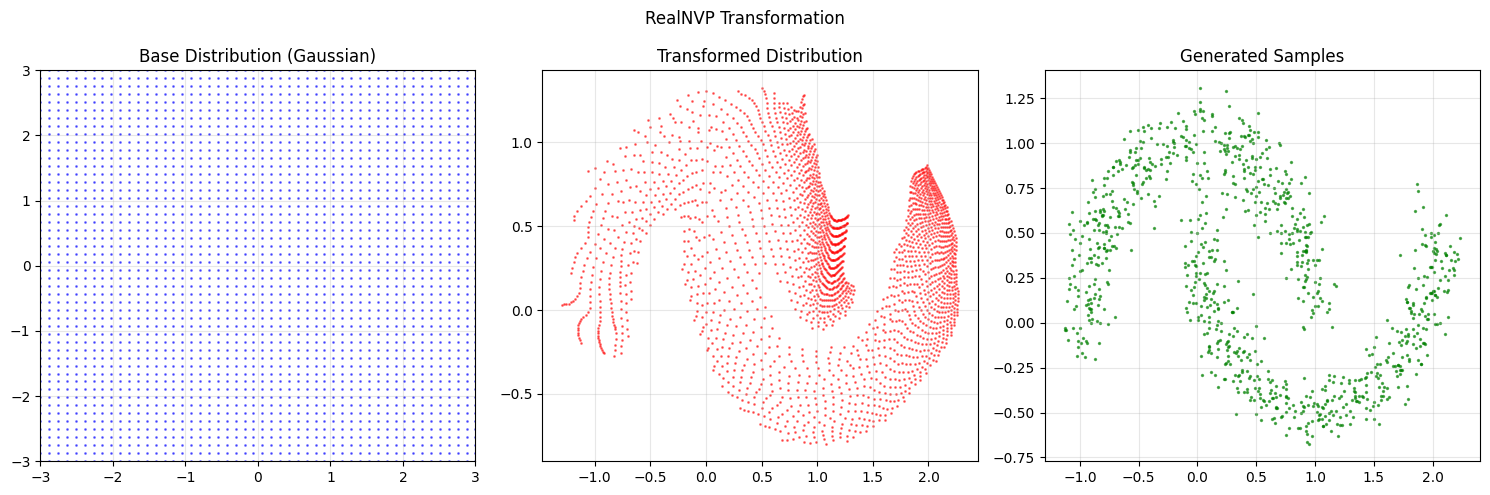

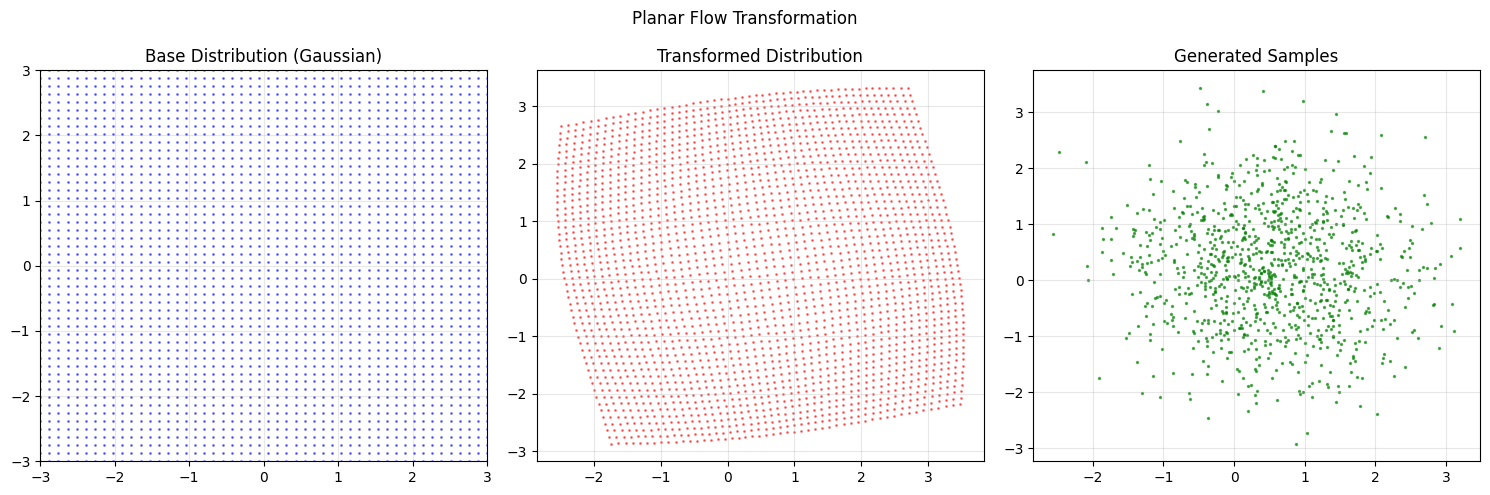

In [8]:
def visualize_flow_transformation(model, title="Flow Transformation"):
    """Visualize how a flow transforms the base distribution"""
    model.eval()
    
    # Create a grid in the base space
    n_points = 50
    x = np.linspace(-3, 3, n_points)
    y = np.linspace(-3, 3, n_points)
    X, Y = np.meshgrid(x, y)
    grid_points = np.column_stack([X.ravel(), Y.ravel()])
    
    # Transform grid points
    with torch.no_grad():
        z = torch.FloatTensor(grid_points).to(device)
        if hasattr(model, 'forward'):
            x_transformed, _ = model.forward(z)
        else:
            x_transformed = model.forward(z)
        x_transformed = x_transformed.detach().cpu().numpy()
    
    # Sample from the model
    samples = model.sample(1000).detach().cpu().numpy()
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Base distribution
    axes[0].scatter(grid_points[:, 0], grid_points[:, 1], alpha=0.5, s=1, c='blue')
    axes[0].set_title('Base Distribution (Gaussian)')
    axes[0].set_xlim(-3, 3)
    axes[0].set_ylim(-3, 3)
    axes[0].grid(True, alpha=0.3)
    
    # Transformed distribution
    axes[1].scatter(x_transformed[:, 0], x_transformed[:, 1], alpha=0.5, s=1, c='red')
    axes[1].set_title('Transformed Distribution')
    axes[1].grid(True, alpha=0.3)
    
    # Generated samples
    axes[2].scatter(samples[:, 0], samples[:, 1], alpha=0.6, s=2, c='green')
    axes[2].set_title('Generated Samples')
    axes[2].grid(True, alpha=0.3)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualize transformations
visualize_flow_transformation(realnvp, "RealNVP Transformation")
visualize_flow_transformation(planar_flow, "Planar Flow Transformation")

## Comparing Generated Samples with Real Data

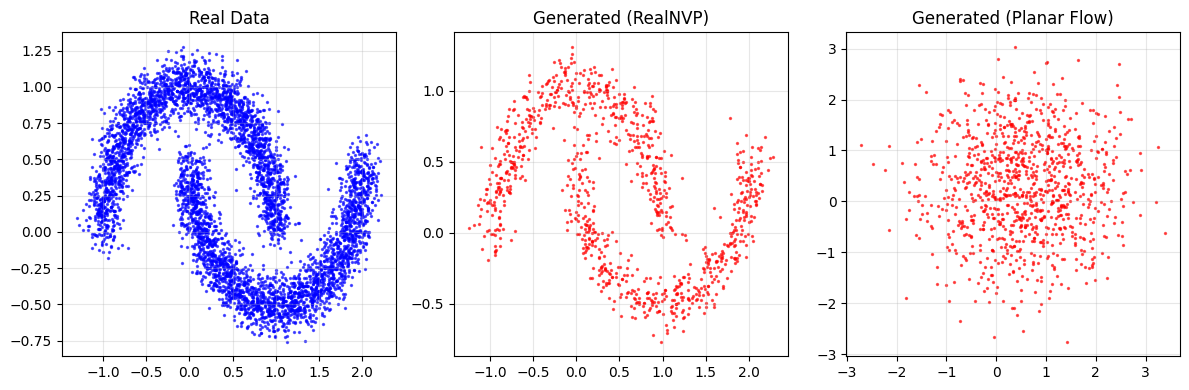

In [9]:
def compare_real_vs_generated(real_data, models, model_names):
    """Compare real data with generated samples"""
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models + 1, figsize=(4 * (n_models + 1), 4))
    
    # Plot real data
    axes[0].scatter(real_data[:, 0], real_data[:, 1], alpha=0.6, s=2, c='blue')
    axes[0].set_title('Real Data')
    axes[0].grid(True, alpha=0.3)
    
    # Plot generated data
    for i, (model, name) in enumerate(zip(models, model_names)):
        model.eval()
        with torch.no_grad():
            samples = model.sample(1000).detach().cpu().numpy()
        
        axes[i + 1].scatter(samples[:, 0], samples[:, 1], alpha=0.6, s=2, c='red')
        axes[i + 1].set_title(f'Generated ({name})')
        axes[i + 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Compare models
models = [realnvp, planar_flow]
model_names = ['RealNVP', 'Planar Flow']
compare_real_vs_generated(moons_data.detach().cpu().numpy(), models, model_names)

## Likelihood Visualization

RealNVP Likelihood Surface:


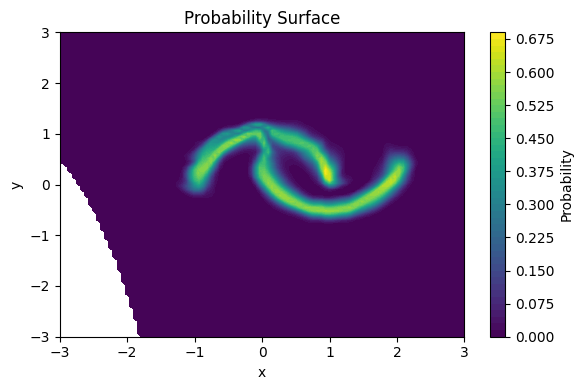

In [10]:
def plot_likelihood_surface(model, xlim=(-3, 3), ylim=(-3, 3), n_points=100):
    """Plot the likelihood surface learned by the model"""
    model.eval()
    
    # Create grid
    x = np.linspace(xlim[0], xlim[1], n_points)
    y = np.linspace(ylim[0], ylim[1], n_points)
    X, Y = np.meshgrid(x, y)
    grid_points = np.column_stack([X.ravel(), Y.ravel()])
    
    # Compute log probabilities
    with torch.no_grad():
        points = torch.FloatTensor(grid_points).to(device)
        log_probs = model.log_prob(points).detach().cpu().numpy()
    
    # Reshape for plotting
    log_prob_grid = log_probs.reshape(X.shape)
    prob_grid = np.exp(log_prob_grid)
    
    # Plot
    plt.figure(figsize=(6, 4))
    
    plt.contourf(X, Y, prob_grid, levels=50, cmap='viridis')
    plt.colorbar(label='Probability')
    plt.title('Probability Surface')
    plt.xlabel('x')
    plt.ylabel('y')
    
    plt.tight_layout()
    plt.show()

# Plot likelihood surfaces for RealNVP
print("RealNVP Likelihood Surface:")
plot_likelihood_surface(realnvp)

## Flows for High-Dimensional Data (MNIST)

Let's apply flows to a higher-dimensional dataset

## Exercises

Now it's your turn to experiment with normalizing flows! Try these exercises:

### Exercise 1: Implement Glow
Implement the Glow architecture with invertible 1x1 convolutions

In [11]:
# Exercise 1: Glow Architecture
class Invertible1x1Conv(FlowLayer):
    def __init__(self, num_channels):
        super(Invertible1x1Conv, self).__init__()
        # TODO: Implement invertible 1x1 convolution
        # Initialize with a random orthogonal matrix
        pass
    
    def forward(self, x):
        # TODO: Apply 1x1 convolution
        pass
    
    def inverse(self, x):
        # TODO: Apply inverse 1x1 convolution
        pass
    
    def log_det_jacobian(self, x):
        # TODO: Compute log determinant
        pass

class ActNorm(FlowLayer):
    def __init__(self, num_channels):
        super(ActNorm, self).__init__()
        # TODO: Implement activation normalization
        # Data-dependent initialization
        pass

class GlowBlock(nn.Module):
    def __init__(self, num_channels):
        super(GlowBlock, self).__init__()
        # TODO: Combine ActNorm + Invertible1x1Conv + Coupling
        pass

### Exercise 2: Implement Neural Spline Flows
Implement flows using rational quadratic splines

In [12]:
# Exercise 2: Neural Spline Flows
def rational_quadratic_spline(inputs, widths, heights, derivatives, inverse=False):
    """
    Rational quadratic spline transformation
    
    Args:
        inputs: input values
        widths: bin widths
        heights: bin heights  
        derivatives: derivatives at bin boundaries
        inverse: whether to compute inverse transformation
    """
    # TODO: Implement rational quadratic spline
    # This involves solving quadratic equations
    pass

class SplineCouplingLayer(FlowLayer):
    def __init__(self, dim, num_bins=10, hidden_dim=64):
        super(SplineCouplingLayer, self).__init__()
        # TODO: Implement coupling layer with spline transformations
        pass

# Implement and compare with RealNVP

### Exercise 3: Implement Masked Autoregressive Flow (MAF)
Build an autoregressive flow using MADE architecture

In [13]:
# Exercise 3: Masked Autoregressive Flow
class MaskedLinear(nn.Module):
    def __init__(self, in_features, out_features, mask):
        super(MaskedLinear, self).__init__()
        # TODO: Implement masked linear layer for MADE
        pass

class MADE(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(MADE, self).__init__()
        # TODO: Implement Masked Autoencoder for Distribution Estimation
        # Ensure autoregressive property through masking
        pass

class MAF(nn.Module):
    def __init__(self, dim, n_flows=5):
        super(MAF, self).__init__()
        # TODO: Stack MADE networks with alternating orderings
        pass

# Compare MAF with RealNVP on toy datasets

### Exercise 4: Continuous Normalizing Flows (Neural ODEs)
Implement flows using neural ODEs

In [14]:
# Exercise 4: Continuous Normalizing Flows
class CNF(nn.Module):
    def __init__(self, dim, hidden_dim=64):
        super(CNF, self).__init__()
        # TODO: Implement continuous normalizing flow
        # Use neural ODEs for the transformation
        # Note: This requires torchdiffeq package
        pass
    
    def forward(self, x, integration_times):
        # TODO: Solve ODE forward in time
        pass
    
    def inverse(self, x, integration_times):
        # TODO: Solve ODE backward in time
        pass

# Compare computational efficiency with discrete flows

## Summary

In this tutorial, we've covered:

1. **Flow Fundamentals**: Change of variables and Jacobian determinants
2. **Basic Flows**: Planar and radial transformations
3. **RealNVP**: Coupling layers for practical invertible transformations
4. **Training**: Maximum likelihood estimation with exact log-likelihood

Key takeaways:
- Flows provide exact likelihood computation and sampling
- Invertibility constraints limit architectural choices
- Coupling layers are a practical solution for high-dimensional data
- Different flow architectures have different trade-offs

### Advantages of Normalizing Flows:
- **Exact likelihood**: No approximations needed
- **Exact sampling**: Direct transformation from base distribution
- **Stable training**: Well-defined objective function

### Limitations:
- **Architectural constraints**: Must maintain invertibility
- **Computational cost**: Jacobian determinant computation
- **Expressiveness**: May be limited compared to GANs/VAEs

Normalizing flows are a powerful tool for probabilistic modeling with exact likelihood computation!